In [1]:
import numpy as np
import time
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv2D, MaxPool2D, Reshape, Concatenate, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K

from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

from tensorflow import lite

In [4]:
# Folders
# IMG_SIZE = (256, 256)
# IMG_SIZE = (32,32)
IMG_SIZE = (64, 64)
folder = "Fitzpatrick-imgs/"
pics = folder + "fairface/fairface/"

train_pics = pics + "train/"
test_pics = pics + "val/"

all_pics = pics + "all_pics/"

train_csv = folder + "fitz_undersampled_train_final.csv"
test_csv = folder + "fitz_undersampled_test_final.csv"

In [25]:
# Dataframes
# Columns: file (pic), age, gender, race, phototype
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)

labels = df_train["phototype"].unique()
labels = np.sort(labels)
labels

array(['I & II', 'III', 'IV', 'V', 'VI'], dtype=object)

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [210]:
# print(train_images[0])
print(len(train_images[0]))
print(train_labels)
plt.imshow(cv2.cvtColor(train_images[0],cv2.COLOR_BGR2RGB))
plt.show()

64
[[1]
 [3]
 [1]
 ...
 [4]
 [4]
 [4]]


error: OpenCV(4.2.0) c:\projects\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xe227985e::Set<3,4,-1>,struct cv::impl::A0xe227985e::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


III       7086
IV        7086
I & II    7086
V         7086
VI        7086
Name: phototype, dtype: int64
III       903
IV        903
VI        903
I & II    903
V         903
Name: phototype, dtype: int64


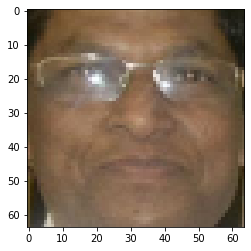

V


In [159]:
train_pics_files = df_train['file']
train_pics_labels = df_train['phototype']
print(train_pics_labels.value_counts())

test_pics_files = df_test['file']
test_pics_labels = df_test['phototype']
print(test_pics_labels.value_counts())

test_pic = train_pics + train_pics_files[4]

image=cv2.imread(test_pic)
image=cv2.resize(image, IMG_SIZE)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

print(train_pics_labels[4])

In [211]:
# Prepare train images

train_images = list()
train_labels = list()

i = 0
for file in train_pics_files:
    cur_pic = all_pics + file
    # if os.path.isfile(cur_pic): # Check if pic exists in files
    try:
        image=cv2.imread(cur_pic)
        image=cv2.resize(image, IMG_SIZE)
        train_images.append(image)

        # train_labels.append(np.where(labels == train_pics_labels[i])[0])
        # Making I, II, III and IV same cat
        if train_pics_labels[i] in ['I & II', 'III', 'IV']:
            train_labels.append(0)
        else:
            train_labels.append(1)
    except:
        print("Error at pic: ", file)
    
    i += 1

train_images = np.array(train_images)
train_images = train_images / 255.0

train_labels = np.array(train_labels)
print(train_labels)
print(len(train_images), len(train_labels))

Error at pic:  28544.jpg
Error at pic:  31948.jpg
Error at pic:  34114.jpg
Error at pic:  47808.jpg
Error at pic:  56453.jpg
[0 1 0 ... 1 1 1]
35425 35425


In [212]:
# Prepare test images
test_images = list()
test_labels = list()

i = 0
for file in test_pics_files:
    cur_pic = all_pics + file
    #if os.path.isfile(cur_pic): # Check if pic exists in files
    try:
        image=cv2.imread(cur_pic)
        image=cv2.resize(image, IMG_SIZE)
        test_images.append(image)
        
        # test_labels.append(np.where(labels == test_pics_labels[i])[0])
        # Making I, II, III and IV same cat
        if test_pics_labels[i] in ['I & II', 'III', 'IV']:
            test_labels.append(0)
        else:
            test_labels.append(1)
    except:
        print("Error at pic: ", file)
    
    i += 1
    
test_images = np.array(test_images)
test_images = test_images / 255.0

test_labels = np.array(test_labels)
print(test_labels)
print(len(test_images), len(test_labels))

[0 0 0 ... 1 1 1]
4515 4515


In [20]:
def make_model(num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes))
    model.summary()
    
    return model

In [172]:
def make_model2(num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    ######## V3 ###############
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    ###### V2 ##########
    # model.add(layers.MaxPooling2D((5, 5)))
    # model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    ######################################
    
    ###### V1 ############
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    ###################################
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    ######### V3 #################
    model.add(layers.Dropout(0.2))
    #############################
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    model.summary()
    
    return model

In [214]:
def make_binary_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    
    return model

In [215]:
# model = make_model2(len(labels))
model = make_binary_model()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 6, 6, 64)       

In [216]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

model.save("CNN_64x64_bin_20epochs")

Epoch 1/20
1108/1108 [==============================] - 55s 49ms/step - loss: 0.5887 - accuracy: 0.6937 - val_loss: 0.6759 - val_accuracy: 0.6496
Epoch 2/20
1108/1108 [==============================] - 56s 50ms/step - loss: 0.5313 - accuracy: 0.7388 - val_loss: 0.6779 - val_accuracy: 0.6554
Epoch 3/20
1108/1108 [==============================] - 54s 49ms/step - loss: 0.5064 - accuracy: 0.7552 - val_loss: 0.6875 - val_accuracy: 0.6605
Epoch 4/20
1108/1108 [==============================] - 54s 49ms/step - loss: 0.4886 - accuracy: 0.7669 - val_loss: 0.7812 - val_accuracy: 0.6565
Epoch 5/20
1108/1108 [==============================] - 54s 49ms/step - loss: 0.4732 - accuracy: 0.7748 - val_loss: 0.7943 - val_accuracy: 0.6478
Epoch 6/20
1108/1108 [==============================] - 54s 49ms/step - loss: 0.4625 - accuracy: 0.7832 - val_loss: 0.8381 - val_accuracy: 0.6591
Epoch 7/20
1108/1108 [==============================] - 55s 50ms/step - loss: 0.4510 - accuracy: 0.7877 - val_loss: 0.8378 -

INFO:tensorflow:Assets written to: CNN_64x64_bin_20epochs\assets


INFO:tensorflow:Assets written to: CNN_64x64_bin_20epochs\assets


In [2]:
model = load_model("CNN_64x64_bin_20epochs")

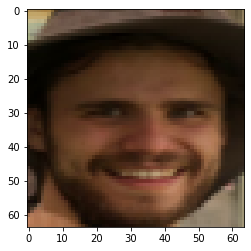

In [6]:
test_pic = "test_pics/pic4.png"
image=cv2.imread(test_pic)
image=cv2.resize(image, IMG_SIZE)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
image = np.array(image)
image = image / 255.0
p = model.predict(np.array([image]))
print(p)
if p[0] <= 0.5:
    print("I, II, III")
else:
    print("V, VI")
    
if p[0] >= 0.40 and p[0] <= 0.70:
    print("Posible IV, V")

1/1 [==============================] - 0s 187ms/step
[[0.03706914]]
I, II, III


In [292]:
converter = lite.TFLiteConverter.from_keras_model(model)
 
tfmodel = converter.convert()
 
open('fitzpatrick.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\Renato\AppData\Local\Temp\tmpppdqjyil\assets


INFO:tensorflow:Assets written to: C:\Users\Renato\AppData\Local\Temp\tmpppdqjyil\assets


819876

In [ ]:
# Extracted from https://github.com/llSourcell/A_Guide_to_Running_Tensorflow_Models_on_Android/blob/master/tensorflow_model/mnist_convnet_keras.py
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

if not path.exists('out'):
    os.mkdir('out')

